**Table of contents**<a id='toc0_'></a>    
- 1. [Correlation distance in Cascadia ](#toc1_)    
- 2. [Load data](#toc2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>Correlation distance in Cascadia  [&#128285;](#toc0_)

In [1]:
# Imports
%matplotlib widget
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LongitudeLocator, LatitudeLocator

import os
import sys
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    sys.path.append('/home/gafarge/py_modules/my_modules')
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    sys.path.append('/Users/gaspard/Documents/work/py_modules/my_modules')
    workdir = '/Users/gaspard/Documents/work/'
from geostuff import transect

# 2. <a id='toc2_'></a>Load data [&#128285;](#toc0_)
Directly from pre-processed catalogs — with earthquake counts and modeled depths.

In [2]:
# Load tremor
trm = pd.read_csv('data/cascadia/processed/casc_trm_0809_0624_zb19_dist.csv', parse_dates=['date'])

In [3]:
# Load earthquakes
eq = pd.read_csv('data/cascadia/processed/casc_eqmc1.5_0809_0624_dist.csv', parse_dates=['date'])

In [4]:
# Project along strike
crs = ccrs.TransverseMercator(central_longitude=trm.lon.mean(), central_latitude=trm.lat.mean())

In [5]:
crs

<Projected CRS: +proj=tmerc +ellps=WGS84 +lon_0=-123.4129000442145 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Transverse Mercator
Datum: Unknown based on WGS 84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [37]:
coords = crs.transform_points(ccrs.PlateCarree(), trm.lon.values, trm.lat.values)
trm.loc[:, 'x'] = coords[:, 0] / 1e3  # in km
trm.loc[:, 'y'] = coords[:, 1] / 1e3  # in km

p = np.polyfit(trm.y, trm.x, 4)

In [93]:
def poly_proj(x, y, poly_coeffs, min_dot=1e-6):
    """Orthogonally projects a point M onto a polynomial curve.
    
    Dirty implementation of getting the projection to be orthogonal, but it works.
    """
    # Select initial guess for where the point is projected on the line P
    x_proj, y_proj = x, np.polyval(poly_coeffs, x)

    dot = 1.
    while abs(dot) > 1e-1:
        # Vector from P (projected guess) to M (chosen point)
        PM = np.array([x - x_proj, y - y_proj])

        # Vector tangent to the curve at P
        dP = np.array([1, np.polyval(np.polyder(poly_coeffs), x_proj)])

        # Dot product between PM and dP
        dot =  np.dot(PM, dP)

        # Update
        x_proj += dot / 10
        y_proj = np.polyval(poly_coeffs, x_proj)

    return x_proj, y_proj, dot

In [145]:
def dist_along_poly(x, x0, poly_coeffs):
    """Returns the distance along a polynomial curve from x0 to x.
    """
    # Integrate the arcs along the curve between x0 and x
    dx_int = .1
    x_int = np.arange(x0, x+dx_int, dx_int)
    s = np.trapz(np.sqrt(1 + (np.polyval(np.polyder(poly_coeffs), x_int))**2), x_int)
    
    return s

Distance from first point in km 290.5894213047473


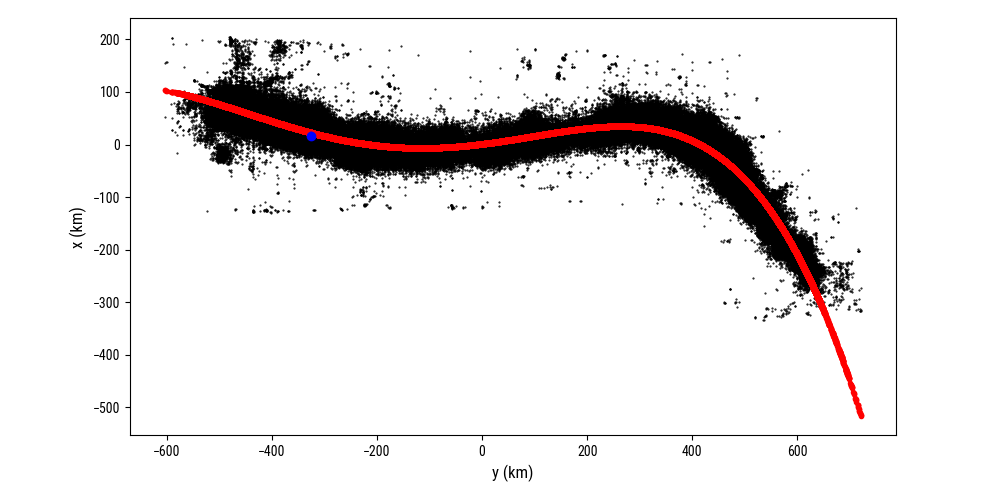

In [147]:
# For one point
ii = np.argmin(trm.x) + 100

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_aspect('equal')
ax.set_xlabel('y (km)')
ax.set_ylabel('x (km)')

ax.plot(trm.y, trm.x, 'k.', ms=1)
ax.plot(np.sort(trm.y), np.polyval(p, np.sort(trm.y)), 'r.', label='Fit')

y_proj, x_proj, dot = poly_proj(trm.y[ii], trm.x[ii], p)
dx_int = .1
x_int = np.arange(trm.y.min(), y_proj+dx_int, dx_int)
s = np.trapz(np.sqrt(1 + (np.polyval(np.polyder(p), x_int))**2), x_int)
print('Distance from first point in km', s)

ax.plot(trm.y[ii], trm.x[ii], 'bo')
ax.plot([trm.y[ii], y_proj], [trm.x[ii],x_proj], 'b-')

plt.tight_layout()
plt.show()

In [118]:
# For all points
y_proj = np.zeros(trm.shape[0])
x_proj = np.zeros(trm.shape[0])

for ii in range(trm.shape[0]):
    print('{:d}/{:d}'.format(ii, trm.shape[0]), end='\r')
    x_proj[ii], y_proj[ii], dot = poly_proj(trm.y[ii], trm.x[ii], p)

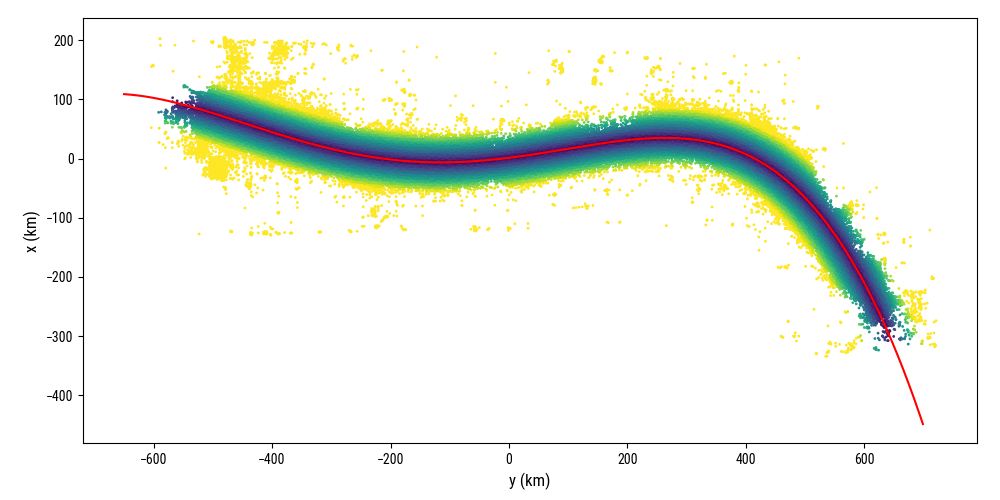

In [126]:
# Compute the distance across strike
d_across_strike = np.sqrt((trm.y - x_proj)**2 + (trm.x - y_proj)**2)
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_aspect('equal')
ax.set_xlabel('y (km)')
ax.set_ylabel('x (km)')

ax.scatter(trm.y, trm.x, s=1, c=d_across_strike, cmap='viridis', vmax=50)
ax.plot(np.arange(-650, 700, 1), np.polyval(p, np.arange(-650, 700, 1)), 'r-', label='Fit')

plt.tight_layout()
plt.show()

In [141]:
# Compute distance along strike
d_along_strike = np.zeros(trm.shape[0])

for ii in range(trm.shape[0]):
    print('{:d}/{:d}'.format(ii, trm.shape[0]), end='\r')
    d_along_strike[ii] = dist_along_poly(y_proj[ii], trm.y.min(), p)

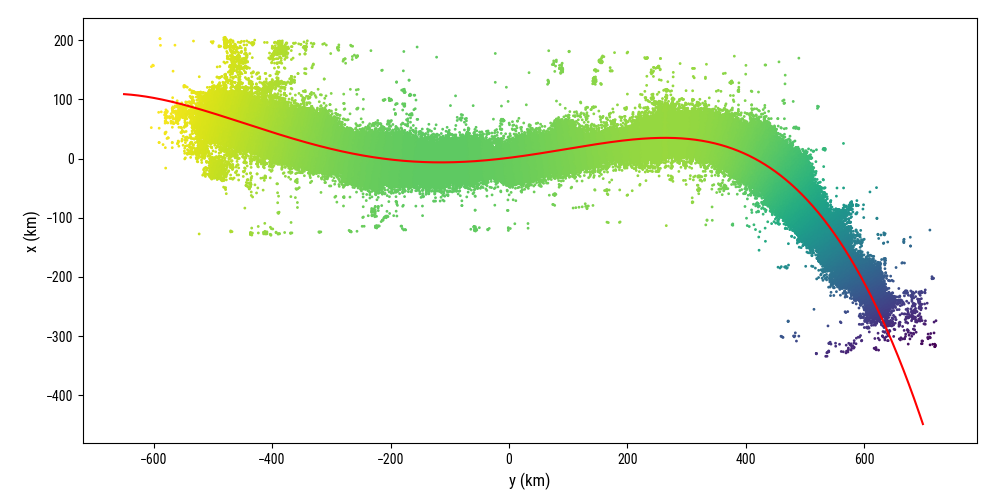

In [143]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_aspect('equal')
ax.set_xlabel('y (km)')
ax.set_ylabel('x (km)')

# ax.scatter(trm.y, trm.x, s=1, c=d_along_strike%50, cmap='twilight', vmax=50)
ax.scatter(trm.y, trm.x, s=1, c=d_along_strike, cmap='viridis')
ax.plot(np.arange(-650, 700, 1), np.polyval(p, np.arange(-650, 700, 1)), 'r-', label='Fit')

plt.tight_layout()
plt.show()